# Goal
* Generate many functions. 
    * Model the function with an MLP and fit with 300 epochs
    * Use the MLP to find $dydx$ and $d2y/d2x$ using `torch.autograd.grad`.
    * Use the  range of -1 to 1
    * Calculate the expected $dydx$ and $d2y/d2x$ for each function using sympy
    * Compare the L1 error between the analytical values and the MLP evaluted values for $dydx$ and $d2y/d2x$ 
    * Record the error values 
    * Plot the performance of the MLP to model the function and its deriviates


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from  sympy import *
import random
import numpy as np
import warnings

In [2]:
%matplotlib inline

In [3]:
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, _input):
        return mish(_input)
    
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, _input):
        return torch.sin(_input)
    
def make_batch(x): return x[:,None]

def debatch(x, detach = True):
    x =  x.squeeze()
    if detach: x = x.detach()
    return x

def make_mlp(n = 20, layers_count = 3, act = Mish):
    layers = []
    layers.append(nn.Linear(1,n))
    layers.append(act())
    for i in range(layers_count -2):
        layers.append(nn.Linear(n,n))
        layers.append(act())
    layers.append(nn.Linear(n,1))
    mlp = nn.Sequential(*layers)
    return mlp

class Stepper:
    clear_grad = True
    def __call__(self,my_mlp,xb, yb, lr = 1e-1):
        yprime = my_mlp(xb)
        self.loss = F.mse_loss(yb,yprime )
        self.loss.backward()
        for name, param in my_mlp.named_parameters():
            param.data = param.data - param.grad*lr
        if self.clear_grad: my_mlp.zero_grad()
        self.yprime = yprime
        return yprime.squeeze().detach()

In [4]:
do_step = Stepper()

# Randomly generate an equation

In [6]:
x = symbols("x")

In [7]:
def add(x1,x2): return x1-x2
def minus(x1, x2): return x1-x2
def power(x1, x2): return x1**x2
def identity(x1): return x1
# def sin_with_frequency(x1, x2): return sin(x1*x2)

Here we are making a list of operations we might use. We break it up into two types of operations
* operations with just a single input
* operations with a input and a second number

In [8]:
fns = [cos, sin, identity]
fns2 = [add, minus, power]

Make an expression will combine together `number_of_num_fncs` of operations together. For each operation it will first randomly pick an operation in the list `fns` or `fns2` with the only difference being that for `fns2` operations, it will need to generate another random value as an additional argument to the operation.  

In [9]:
def make_equation(number_of_num_fncs):
    y  = 1
    for i in range(number_of_num_fncs):
        if random.randint(0,1)==0:
            # only requires 1 input. 
            fn = random.choice(fns)
            y = y*fn(x)
        else:
            # requires 2 inputs. 
            fn = random.choice(fns2)
            value = random.random()-0.5
            # now choose if x is the input
            if type(y)!=int and  y.has(x): # first, make sure y already has an x in its expression
                if random.randint(0,1)==0:
                    y = y*fn(x,value) # just use x as the input
                else:
                    print(f"making composite, fn is {fn} and  y = {y}")
                    y = fn(y,value) # do a composite function
                    
            else:
                # if missing x in the express, then we need to use X for sure as the 1st input. 
                y = y*fn(x,value)
#         print(i, y)

    # catch the special case where everything cancels out. Just make the identity function
    if type(y)==int or  y.has(x)== False:
        print(f"catching function with nothing {y}")
        y = x
    return y
    

We call `make_equation` twice for the numerator and operator, then combine the results to make a whole equation. 

In [10]:
def make_whole_equation(possible_operations = 3, min_operations = 1):
    number_of_num_fncs_numerator = random.randint(min_operations,possible_operations)
    number_of_num_fncs_denominator = random.randint(min_operations,possible_operations)
#     print(number_of_num_fncs_numerator,number_of_num_fncs_denominator )
    numerator = make_equation(number_of_num_fncs_numerator)
    denominator = make_equation(number_of_num_fncs_numerator)
    equation = numerator/denominator
    return equation

In [35]:
equation = make_whole_equation()
equation

making composite, fn is <function add at 0x00000226612A30D0> and  y = x + 0.0894373150926914


(x + 0.274240463837261)/((x - 0.144811904471277)*sin(x))

We take the symbolic equation and convert it to a numpy function using `lambdify`. Then we evalute the function at the points in `x_numeric` and then plot to see if everything is working. 

In [36]:
f = lambdify(x, equation, "numpy")

In [37]:
x_numeric = np.linspace(-1,1, 40)

In [38]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y = f(x_numeric)
    y = np.nan_to_num(y)

(-1.0, 1.0)

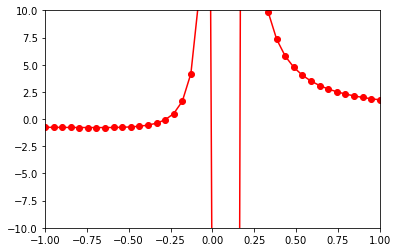

In [39]:
plt.plot(x_numeric, y, 'ro-')
plt.ylim([-10,10])
plt.xlim([-1,1])

Next, we calculate the analytical first derivative. Then we turn the function into a numpy function, evalute, and plot. 

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
#     dydx = simplify( diff(equation, x))
    dydx =  diff(equation, x)

In [17]:
dydx

cos(x)/(x + 0.0739198442216734) - sin(x)/(x + 0.0739198442216734)**2

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    f_dydx = lambdify(x, dydx, "numpy")
    dydx_values = f_dydx(x_numeric)
    dydx_values = np.nan_to_num(dydx_values)

(-1.0, 1.0)

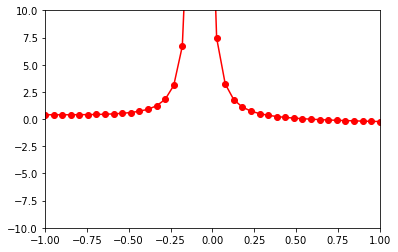

In [19]:
plt.plot(x_numeric, dydx_values, 'ro-')
plt.ylim([-10,10])
plt.xlim([-1,1])

We do the same thing for hte 2nd derivative. 

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    d2yd2x =  diff(dydx, x)
    f_d2yd2x = lambdify(x, d2yd2x, "numpy")
    d2yd2x_values = f_d2yd2x(x_numeric)
    d2yd2x_values = np.nan_to_num(d2yd2x_values)

(-1.0, 1.0)

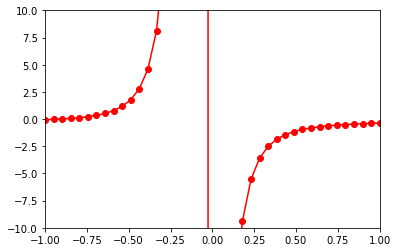

In [21]:
plt.plot(x_numeric, d2yd2x_values, 'ro-')
plt.ylim([-10,10])
plt.xlim([-1,1])

In [22]:
# d2yd2x

## MLP
* make an mlp
* fit it to y values 
* measure the error for y, dydx, and d2yd2x

In [23]:
class Normalizer:
    def __init__(self, values):
        self.mean = values.mean()
        self.std = values.std()
    
    def norm(self, values):
        return  (values - self.mean)/self.std
    
    def denorm(self, values):
        return values*self.std + self.mean

In [24]:
# mlp

Notes:
* convert nan's to 0 and infinity to a large number with `nan_to_num`
* convert to tensor
* convert to batch format
* convert to float32

In [25]:
# x_numeric_t, y_t = [torch.tensor(z) for z in  [x_numeric,y]]
xb, yb = [make_batch(torch.tensor(np.nan_to_num(z))).to(torch.float32) for z in [x_numeric,y]]
yb_normalizer = Normalizer(yb)
yb_norm = yb_normalizer.norm(yb)

In [26]:
# yb_norm

## Train the MLP
* a learning rate higher than 1e-2 is generally unstable. 

In [27]:
from fastcore.basics import store_attr
from torch.optim import *

In [28]:
class Stepper_v2:
    """Uses Adam optimizer rather than just SGD. Adam is much better. """
    def __init__(self, my_mlp, xb, yb, lr = 0.001):
        store_attr("my_mlp, xb, yb, lr")
        
    def do_epochs(self, epochs, lr = None):
        lr = self.lr if lr is None else lr
        self.optimizer = Adam(self.my_mlp.parameters(), lr = lr)
        self.loss_list = []
        for i in range(epochs):
            self.optimizer.zero_grad()
            self.yprime = self.my_mlp(self.xb)
            self.loss = F.mse_loss(self.yb,self.yprime )
            self.loss.backward()
            self.optimizer.step()
            self.loss_list.append(self.loss.detach())
            
   

In [29]:
mlp = make_mlp(n = 100, layers_count=3, act = Mish)

In [30]:
do_step2 = Stepper_v2(mlp, xb, yb_norm)

In [31]:
do_step2.do_epochs(int(1e4), lr = 1e-4)

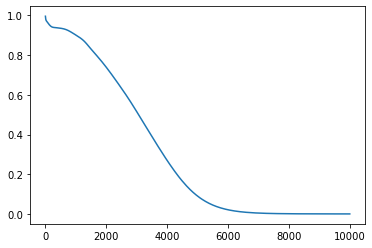

In [32]:
plt.plot(do_step2.loss_list)

(-1.0, 1.0)

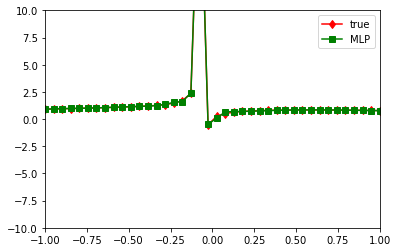

In [33]:
yprime = mlp(xb)

yprime_debatch = yb_normalizer.denorm(   debatch(yprime))
# x_debatch = debatch(x)

plt.plot(x_numeric,y, "rd-", label = "true")
plt.plot(x_numeric,yprime_debatch, "gs-", label = "MLP")
plt.legend()
plt.ylim([-10,10])
plt.xlim([-1,1])

In [34]:
xb.requires_grad = True
yprime_pre = mlp(xb)
yprime_pre.retain_grad()
# yprime_pre.requires_grad = True
yprime = yb_normalizer.denorm(   yprime_pre)

dydx = torch.autograd.grad(yprime.sum(), xb, create_graph=True)[0]

d2yd2x = torch.autograd.grad(dydx.sum(), xb, create_graph=True)[0]

(-1.0, 1.0)

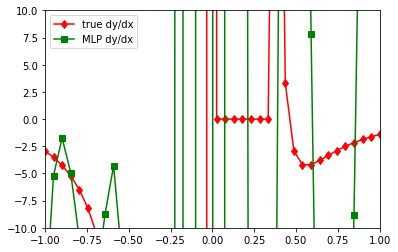

In [712]:
plt.plot(x_numeric,dydx_values, "rd-", label = "true dy/dx")
plt.plot(x_numeric,debatch(dydx), "gs-", label = "MLP dy/dx")
plt.legend()

# plt.plot(x_numeric, dydx_values, 'ro-')
plt.ylim([-10,10])
plt.xlim([-1,1])

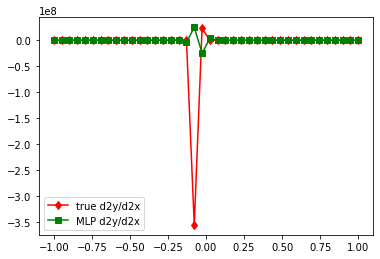

In [713]:
plt.plot(x_numeric,d2yd2x_values, "rd-", label = "true d2y/d2x")
plt.plot(x_numeric,debatch(d2yd2x), "gs-", label = "MLP d2y/d2x")
plt.legend()

# Put it all together now in a loop
* 

In [411]:
# # yprime_debatch

# # yprime





# for i in range(300):
#     yprime_out = do_step(mlp, xb, yb, lr = 1e-1)

# plt.plot(x,y, "rd-", label = "true")
# plt.plot(x,yprime_out, "gs-", label = "MLP")
# plt.legend()

# xb.requires_grad = True
# yprime = mlp(xb)

# dydx = torch.autograd.grad(yprime.sum(), xb, create_graph=True)[0]

# d2yd2x = torch.autograd.grad(dydx.sum(), xb, create_graph=True)[0]

# # y, dydx_analytical, d2yd2x_analytical 



In [412]:
# plt.plot(x,dydx_analytical, "rd-", label = "true dy/dx")
# plt.plot(x,debatch(dydx), "gs-", label = "MLP dy/dx")
# plt.legend()

In [413]:
# plt.plot(x,d2yd2x_analytical, "rd-", label = "true d2y/d2x")
# plt.plot(x,debatch(d2yd2x), "gs-", label = "MLP d2y/d2x")
# plt.legend()